# Merging CSV's

In [2]:
import pandas as pd
import json
import os

# Loading Datsets

In [3]:
DATA_DIR = 'archive/'

In [4]:
df_bal = pd.read_csv(
    os.path.join(DATA_DIR,'cleaned_balance_data.csv'),
    usecols=['local_time','demand','city'],
    engine='python'
)

# Balancing (Phoenix, Seattle) 

In [ ]:

df_bal['Timestamp'] = pd.to_datetime(df_bal['local_time'])
df_bal = df_bal[['Timestamp','demand','city']]
df_bal = df_bal.dropna()

In [6]:
#   b) “Subregion” (NYC)
df_sub = pd.read_csv(
    os.path.join(DATA_DIR,'cleaned_subregion_data.csv'),
    usecols=['local_time','demand','city'],
    engine='python'
)

In [7]:
df_sub['Timestamp'] = pd.to_datetime(df_sub['local_time'])
df_sub = df_sub[['Timestamp','demand','city']]
df_sub = df_sub.dropna()

In [8]:
#   c) Texas (Houston, San Antonio, Dallas)
df_tex = pd.read_csv(
    os.path.join(DATA_DIR,'cleaned_texas_data.csv'),
    usecols=['date','houston','san antonio','dallas'],
    engine='python'
)

In [9]:
df_tex['Timestamp'] = pd.to_datetime(df_tex['date'])
df_tex = df_tex.melt(
    id_vars=['Timestamp'], var_name='city', value_name='demand'
)
df_tex = df_tex[20423:81692]

In [10]:
demand_df = pd.concat([df_bal, df_sub, df_tex], ignore_index=True)
demand_df['city'] = demand_df['city'].str.lower()

#  Loading weather (JSON per city)

In [ ]:

weather_frames = []
for fname in os.listdir(DATA_DIR):
    if fname.endswith('.json'):
        city = fname.replace('.json','')
        arr = json.load(open(os.path.join(DATA_DIR,fname)))
        w = pd.DataFrame(arr)
        w['Timestamp'] = pd.to_datetime(w['time'],unit='s')
        w['city']      = city
        weather_frames.append(
            w[['Timestamp','temperature','humidity','windSpeed','city','pressure','precipIntensity']]
        )
weather_df = pd.concat(weather_frames, ignore_index=True)
weather_df['city'] = weather_df['city'].str.lower()
weather_df.loc[weather_df['city'] == 'san_diego', 'city'] = 'san diego'
weather_df.loc[weather_df['city'] == 'san_jose', 'city'] = 'san jose'
weather_df.loc[weather_df['city'] == 'san_antonio', 'city'] = 'san antonio'

In [12]:
weather_df = weather_df.dropna()

In [13]:
df = demand_df.merge(weather_df, on=['city','Timestamp'], how='inner')
print("Combineddfset:", df.shape)

Combineddfset: (185886, 8)


In [14]:
df = df.drop_duplicates(subset=['Timestamp', 'city'])

In [15]:
df

,Timestamp,demand,city,temperature,humidity,windSpeed,pressure,precipIntensity
0,2018-07-01 07:00:00,2764.0,phoenix,86.82,0.16,4.30,1008.9,0.0000
1,2018-07-01 08:00:00,2895.0,phoenix,83.37,0.19,4.00,1009.3,0.0000
2,2018-07-01 09:00:00,3096.0,phoenix,82.22,0.18,2.47,1009.5,0.0000
3,2018-07-01 10:00:00,3293.0,phoenix,80.34,0.19,2.98,1010.1,0.0000
4,2018-07-01 11:00:00,3552.0,phoenix,79.34,0.18,2.74,1010.4,0.0000
...,...,...,...,...,...,...,...,...
177723,2019-05-26 22:00:00,15411.69,dallas,88.63,0.49,12.51,1015.1,0.0000
177724,2019-05-26 23:00:00,14492.96,dallas,88.24,0.50,12.94,1014.3,0.0000
177725,2019-05-26 00:00:00,13487.94,dallas,86.89,0.56,13.25,1013.2,0.0009
177749,2019-05-27 00:00:00,13444.7,dallas,86.40,0.54,11.80,1014.2,0.0006


In [16]:
df['city'].value_counts()

city
nyc             16445
la              16385
san diego       16384
san jose        16384
dallas          16195
houston         16192
san antonio     16192
phoenix         15892
seattle         15862
philadelphia    14708
Name: count, dtype: int64

In [17]:
df.isnull().sum()   

Timestamp          0
demand             0
city               0
temperature        0
humidity           0
windSpeed          0
pressure           0
precipIntensity    0
dtype: int64

In [18]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Checking for missing values in the dataset

In [ ]:

missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)


Missing Values:
Timestamp          0
demand             0
city               0
temperature        0
humidity           0
windSpeed          0
pressure           0
precipIntensity    0
dtype: int64


# Feature Engineering ( Extract time-based features)

In [ ]:

df['hour'] =df['Timestamp'].dt.hour
df['day_of_week'] =df['Timestamp'].dt.dayofweek
df['month'] =df['Timestamp'].dt.month
df['season'] =df['Timestamp'].dt.month % 12 // 3 + 1  # Simplified season extraction


# Normalization ( 'demand' and 'temperature')

In [ ]:

from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()
df[['demand', 'temperature']] = scaler.fit_transform(df[['demand', 'temperature']])


In [ ]:
# displaying data
df.sample(5)

,Timestamp,demand,city,temperature,humidity,windSpeed,pressure,precipIntensity,hour,day_of_week,month,season
68645,2019-04-03 03:00:00,0.028535,san diego,0.522453,0.72,4.18,1015.3,0.0007,3,2,4,2
26635,2019-09-23 17:00:00,0.023250,seattle,0.501004,0.78,9.02,1022.0,0.0020,17,0,9,4
137490,2020-05-05 07:00:00,0.110810,san jose,0.482019,0.47,2.45,1020.2,0.0000,7,1,5,2
46823,2018-12-05 12:00:00,0.036428,san diego,0.419314,0.67,4.06,1013.9,0.0000,12,2,12,1
5675,2019-02-24 08:00:00,0.049157,phoenix,0.336437,0.61,4.68,1025.6,0.0000,8,6,2,1


# Aggregation: Daily statistics for demand and temperature

In [ ]:

df_daily = df.groupby([df['Timestamp'].dt.date, 'city'])[['demand', 'temperature']].mean().reset_index()
df_daily['Timestamp'] = pd.to_datetime(df_daily['Timestamp'])

# Weekly aggregation

In [ ]:

df_weekly = df.groupby([df['Timestamp'].dt.to_period('W'), 'city'])[['demand', 'temperature']].mean().reset_index()
df_weekly['Timestamp'] = df_weekly['Timestamp'].dt.start_time  # Adjusting timestamp to first day of the week

In [26]:
from scipy.stats import zscore

# Calculating z-scores for 'demand' and 'temperature'

In [ ]:

df['demand_zscore'] = zscore(df['demand'])
df['temperature_zscore'] = zscore(df['temperature'])

# Flagging outliers (Z-score > 3 or < -3)

In [ ]:

df['demand_outlier'] = df['demand_zscore'].apply(lambda x: 1 if abs(x) > 3 else 0)
df['temperature_outlier'] = df['temperature_zscore'].apply(lambda x: 1 if abs(x) > 3 else 0)


# Alternatively, use IQR for outlier detection

In [ ]:

Q1 = df['demand'].quantile(0.25)
Q3 = df['demand'].quantile(0.75)
IQR = Q3 - Q1
df['demand_outlier_iqr'] = df['demand'].apply(lambda x: 1 if x < (Q1 - 1.5 * IQR) or x > (Q3 + 1.5 * IQR) else 0)

# IQR method for 'temperature'

In [ ]:

Q1_temp = df['temperature'].quantile(0.25)
Q3_temp = df['temperature'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp
df['temperature_outlier_iqr'] = df['temperature'].apply(
    lambda x: 1 if (x < (Q1_temp - 1.5 * IQR_temp)) or (x > (Q3_temp + 1.5 * IQR_temp)) else 0
)

# Combine z-score and IQR flags into final anomaly indicators
df['demand_anomaly'] = df[['demand_outlier', 'demand_outlier_iqr']].max(axis=1)
df['temperature_anomaly'] = df[['temperature_outlier', 'temperature_outlier_iqr']].max(axis=1)

# Overall anomaly flag (if any feature is anomalous)
df['anomaly'] = df[['demand_anomaly', 'temperature_anomaly']].max(axis=1)


In [31]:
# df.to_csv('preprocessed_electricity_data.csv', index=False)
# print("Preprocesseddfset saved as 'preprocessed_electricity_data.csv'")

In [32]:

print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 160639 entries, 0 to 184592
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Timestamp                160639 non-null  datetime64[ns]
 1   demand                   160639 non-null  float64       
 2   city                     160639 non-null  object        
 3   temperature              160639 non-null  float64       
 4   humidity                 160639 non-null  float64       
 5   windSpeed                160639 non-null  float64       
 6   pressure                 160639 non-null  float64       
 7   precipIntensity          160639 non-null  float64       
 8   hour                     160639 non-null  int32         
 9   day_of_week              160639 non-null  int32         
 10  month                    160639 non-null  int32         
 11  season                   160639 non-null  int32         
 12  demand_zscore        

# Box plot

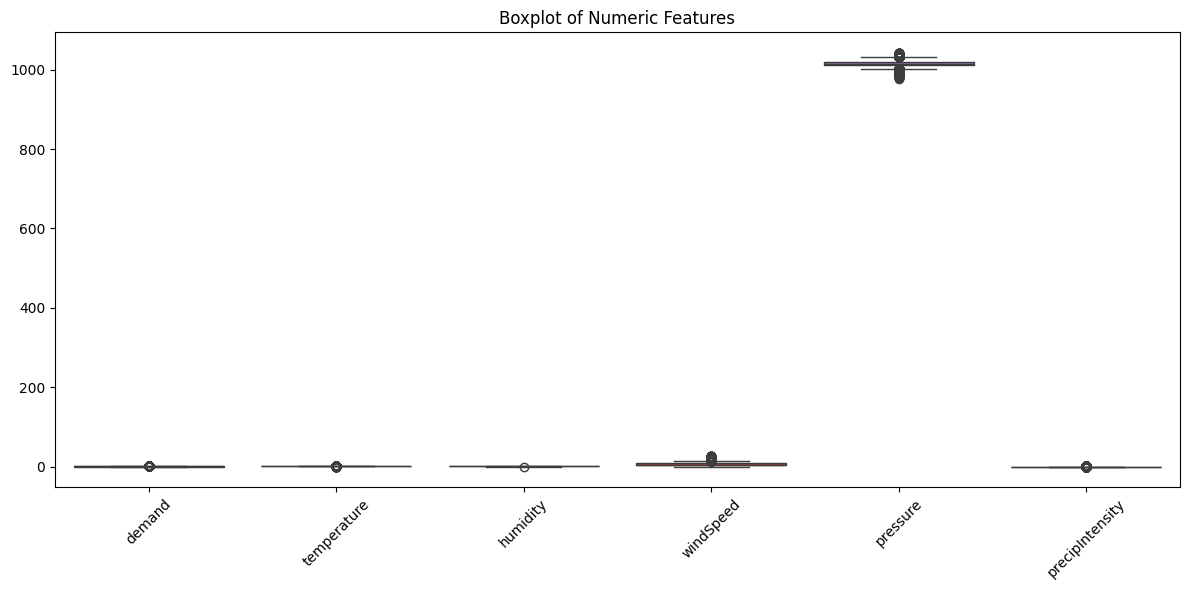

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# # Load your sample data (replace with your actual file or DataFrame)
# df = pd.read_csv("preprocessed_electricity_data.csv", parse_dates=["Timestamp"])

# Select numeric columns for plotting
numeric_cols = ['demand', 'temperature', 'humidity', 'windSpeed', 'pressure', 'precipIntensity']

# Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Numeric Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


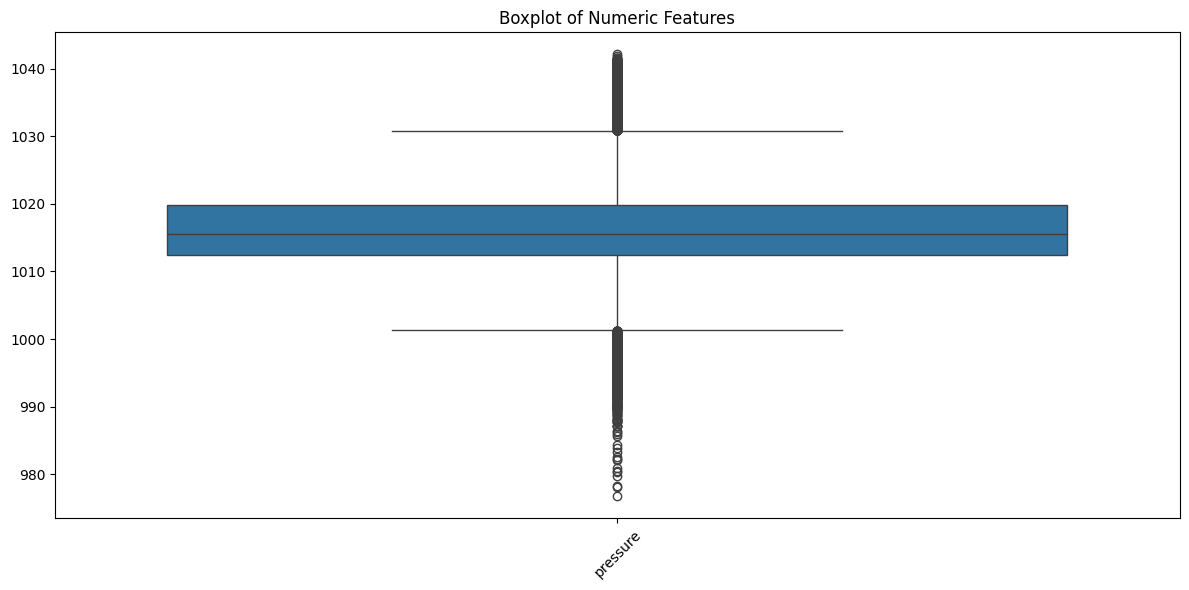

In [34]:
# Select numeric columns for plotting
numeric_cols = [ 'pressure']

# Plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Numeric Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot demand with anomaly markers

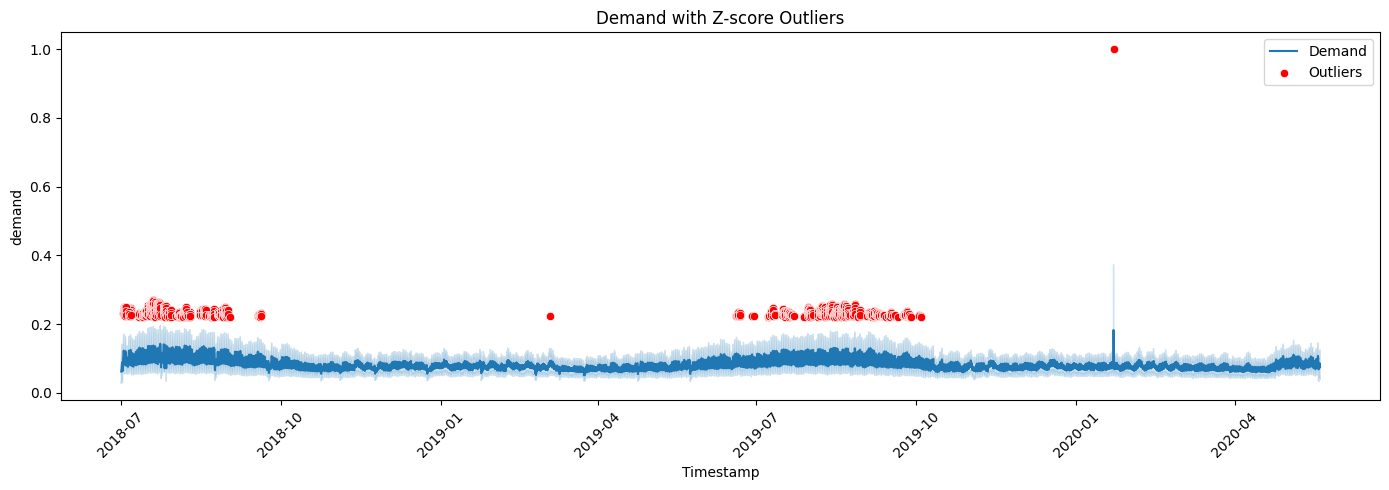

In [ ]:

plt.figure(figsize=(14, 5))
sns.lineplot(x='Timestamp', y='demand', data=df, label='Demand')
sns.scatterplot(x='Timestamp', y='demand', data=df[df['demand_outlier'] == 1],
                color='red', label='Outliers')
plt.title("Demand with Z-score Outliers")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Keep only rows where demand is NOT an outlier

In [ ]:

df_cleaned = df[df['demand_outlier'] == 0].copy()

print(f"Original rows: {len(df)}")
print(f"Rows after removing demand outliers: {len(df_cleaned)}")


Original rows: 160639
Rows after removing demand outliers: 159879


# Remove all rows where any outlier flag is 1

In [ ]:

df_cleaned = df[
    (df['demand_outlier'] == 0) &
    (df['temperature_outlier'] == 0) &
    (df['demand_outlier_iqr'] == 0)
].copy()
print(f"Rows after removing  outliers: {len(df_cleaned)}")


Rows after removing  outliers: 159695


# Scatter plot: demand vs temperature (cleaned data)

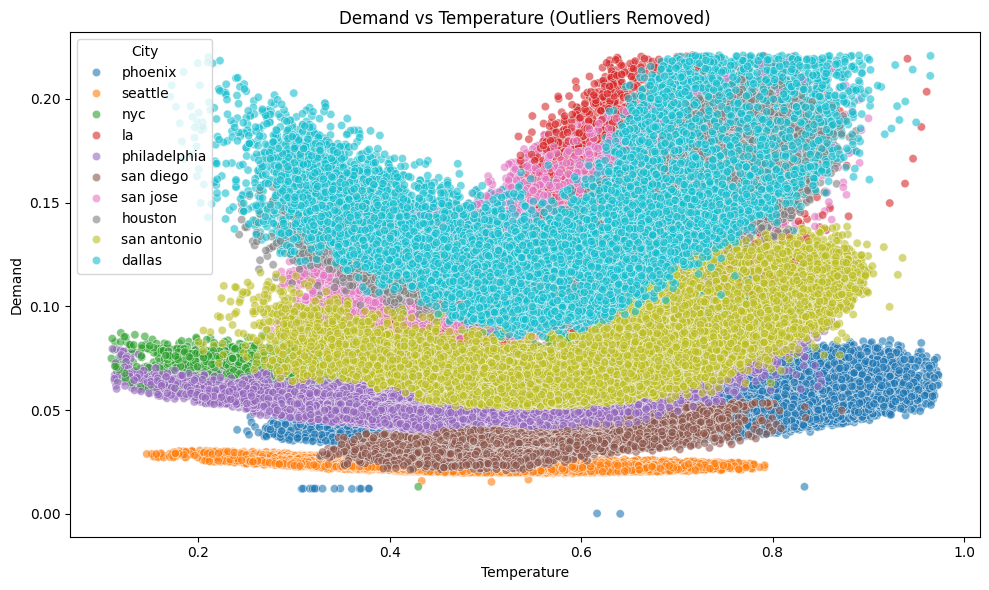

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='temperature', y='demand', hue='city', alpha=0.6)

plt.title("Demand vs Temperature (Outliers Removed)")
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.legend(title='City')
plt.tight_layout()
plt.show()

In [39]:
print(f"Rows after removing  outliers: {len(df_cleaned)}")

Rows after removing  outliers: 159695


In [40]:
df_cleaned.to_csv('data.csv', index=False)
print("Preprocesseddfset saved as 'data.csv'")

Preprocesseddfset saved as 'data.csv'


In [44]:
df_nextday = pd.read_csv('data.csv')

In [46]:
# Shift the demand column to predict next-day demand
df_nextday['demand_next_day'] = df_nextday['demand'].shift(-24)


In [47]:
# Drop rows with NaN values (the last 24 rows for which no future demand is available)
df_nextday = df_nextday.dropna(subset=['demand_next_day'])

In [52]:
df_nextday.to_csv('data_nextday.csv', index=False)
print("Preprocessed dataset saved as 'data_nextday.csv'")

Preprocessed dataset saved as 'data_nextday.csv'


#  final data

In [51]:
# Check the data
df_nextday.head()

,Timestamp,demand,city,temperature,humidity,windSpeed,pressure,precipIntensity,hour,day_of_week,...,demand_zscore,temperature_zscore,demand_outlier,temperature_outlier,demand_outlier_iqr,temperature_outlier_iqr,demand_anomaly,temperature_anomaly,anomaly,demand_next_day
0,2018-07-01 07:00:00,0.039941,phoenix,0.759766,0.16,4.30,1008.9,0.0,7,6,...,-0.943767,1.514676,0,0,0,0,0,0,0,0.043172
1,2018-07-01 08:00:00,0.041216,phoenix,0.728277,0.19,4.00,1009.3,0.0,8,6,...,-0.916012,1.296281,0,0,0,0,0,0,0,0.045021
2,2018-07-01 09:00:00,0.043172,phoenix,0.717780,0.18,2.47,1009.5,0.0,9,6,...,-0.873427,1.223483,0,0,0,0,0,0,0,0.046890
3,2018-07-01 10:00:00,0.045089,phoenix,0.700621,0.19,2.98,1010.1,0.0,10,6,...,-0.831690,1.104473,0,0,0,0,0,0,0,0.049293
4,2018-07-01 11:00:00,0.047610,phoenix,0.691493,0.18,2.74,1010.4,0.0,11,6,...,-0.776816,1.041170,0,0,0,0,0,0,0,0.052388
